In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Data\ventilator-pressure-prediction\train.csv")
data_test = pd.read_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Data\ventilator-pressure-prediction\test.csv")
data_train = data.loc[:, data.columns != 'pressure']
data_train_target = data.loc[:, data.columns == 'pressure']

In [ ]:
##Random Forest
##Simple attept: just use original data to train 
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(max_depth=5, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest.fit(data_train, data_train_target) 
forest.oob_score_

prediction = forest.predict(data_train)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction))

##oob_score_(R2 score) pretty bad. goodness of fit 41%-50%

In [3]:
test = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\simple_model_comparison.csv", index=False)

In [4]:
test

,x,y
0,5.837492,5.861788
1,5.907794,5.861788
2,7.876254,7.722386
3,11.742872,15.448595
4,12.234987,15.448595
...,...,...
6035995,3.869032,4.470888
6035996,3.869032,4.470888
6035997,3.798729,4.470888
6035998,4.079938,4.470888


,R,C,u_in,u_out,pressure
time_step,,,,,
25,10,10,10,10,10
26,3,3,3,3,3
28,123,123,123,123,123
29,22803,22803,22803,22803,22803
30,18260,18260,18260,18260,18260
31,17923,17923,17923,17923,17923
32,16328,16328,16328,16328,16328


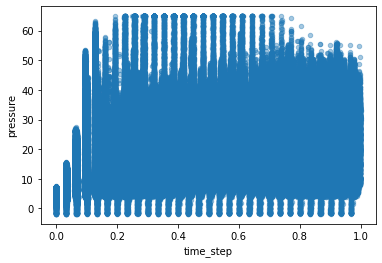

In [14]:
##RandomForest
##filter out exhale breath, only train on input breath
data_inhale = data[(data['u_out'] == 0)]
data_train = data.loc[:, data.columns != 'pressure']
data_train_target = data.loc[:, data.columns == 'pressure']
data_inhale.plot(kind='scatter', x='time_step', y='pressure', alpha = 0.4)

numberOfInhaleTimeSteps = data_inhale.groupby(['breath_id']).count()
numberOfInhaleTimeSteps.groupby(['time_step']).count()

In [2]:
## Data Engineering
## add additonal feature to catagorize input based on time step catagory.
## seems like there are two types of time step delta/increment for a given breath. One has average time step delta around 0.0340
## the other has time step delta/increment around 0.03215125

#Add time index and remove time_step, id and breath_id columns
data_train['time_index'] = (data['id']-1).mod(80)
data_train.drop(columns=['id'], inplace=True)

time_step_mean = data_train.groupby('breath_id')[['time_step']].mean().reset_index()
time_step_mean.rename(columns={'time_step':'time_step_catagory'}, inplace=True)
time_step_catagory_df = pd.merge(data_train, time_step_mean, on=['breath_id'])
time_step_catagory_df.loc[time_step_catagory_df['time_step_catagory'] >=1.3 , 'time_step_catagory'] = 1
time_step_catagory_df.loc[(time_step_catagory_df['time_step_catagory'] < 1.3) & (time_step_catagory_df['time_step_catagory'] > 1), 'time_step_catagory'] = 0

In [3]:
##Data Engineering: 
## add additional 80 features. Use time series as features. Because lung's pressure at any given time is affected by a series of u_in.
u_in_duplicates = data_train['u_in'].to_numpy()
tiled = np.tile(u_in_duplicates, (80,1)).transpose()
numberOfBreathIds = data['breath_id'].nunique()
x_reshaped = np.reshape(tiled, (numberOfBreathIds, 80, 80))
y = x_reshaped.transpose((0, 2, 1))
triangular = np.tril(y, 0)
row_count, column_count = data.shape
updated_data = np.reshape(triangular, (row_count,80))

numberOfAddedFeatures = 80
columnsNames = list(range(0, numberOfAddedFeatures))
new_feature_df = pd.DataFrame(updated_data, columns =columnsNames)
added_features_data = pd.concat([time_step_catagory_df, new_feature_df], axis=1)

#drop breath_id and time_step columns
print(added_features_data['breath_id'].nunique())
added_features_data.drop(columns=['breath_id'], inplace=True)
added_features_data.drop(columns=['time_step'], inplace=True)
added_features_data.drop(columns=['u_in'], inplace=True)

75450


In [8]:
##Random Forest with added history features

from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(max_depth=2, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest.fit(added_features_data, data_train_target) 
forest.oob_score_

<ipython-input-8-62031a9410cd>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(added_features_data, data_train_target)


0.6427782197861038

In [11]:
prediction = forest.predict(added_features_data)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction))

test = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\u_in_features_comparison.csv", index=False)

0.6427880950293768
23.49285507273317


In [13]:
####One hot encoded feature only 
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(max_depth=2, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest.fit(one_hot_encoded_df, data_train_target) 
print(forest.oob_score_)

prediction = forest.predict(one_hot_encoded_df)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction))

test = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\one_hot_encoded_comparison.csv", index=False)


<ipython-input-13-62b919cc999c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(one_hot_encoded_df, data_train_target)


0.5349507602693508
0.5349571183894424
30.584605015282232


In [12]:
####time index & catagory & u_in feature
from sklearn.ensemble import RandomForestRegressor 
forest = RandomForestRegressor(max_depth=30, n_estimators = 50, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest.fit(added_features_data, data_train_target) 
print(forest.oob_score_)

prediction = forest.predict(added_features_data)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction))

test = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test2 = pd.concat([added_features_data, test], axis=1)
test2.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\time_index_catagory_with_u_in_deep30_estimator50.csv", index=False)

<ipython-input-12-fac0fe217350>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest.fit(added_features_data, data_train_target)


0.9954587243997471
0.9990859887873592
0.06011203057521028


In [14]:
####time index & catagory & u_in feature
from sklearn.ensemble import RandomForestRegressor 
forest_15_30 = RandomForestRegressor(max_depth=15, n_estimators = 30, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest_15_30.fit(added_features_data, data_train_target) 
print(forest_15_30.oob_score_)

prediction15_30 = forest_15_30.predict(added_features_data)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction15_30))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction15_30))

#test_15_30 = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
#test_15_30_full = pd.concat([added_features_data, test_15_30], axis=1)
#test_15_30_full.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\time_index_catagory_with_u_in_deep15_estimator30.csv", index=False)

<ipython-input-14-c47f46f62740>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_15_30.fit(added_features_data, data_train_target)
C:\Users\nwang\Anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


0.9954587243997471
0.9756785433162082
1.5995560312500499


In [15]:
####time index & catagory & u_in feature
from sklearn.ensemble import RandomForestRegressor 
forest_40_60 = RandomForestRegressor(max_depth=40, n_estimators = 60, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest_40_60.fit(added_features_data, data_train_target) 
print(forest_40_60.oob_score_)

prediction_40_60 = forest_40_60.predict(added_features_data)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction_40_60))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction_40_60))

test_40_60 = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test_40_60_full = pd.concat([added_features_data, test_40_60], axis=1)
test_40_60_full.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\time_index_catagory_with_u_in_deep40_estimator60.csv", index=False)

<ipython-input-15-8bf763733377>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_40_60.fit(added_features_data, data_train_target)


0.9956958021010649
0.9993637606110303
0.04184373350563439


In [16]:
from sklearn.ensemble import RandomForestRegressor 
forest_60_100 = RandomForestRegressor(max_depth=60, n_estimators = 100, random_state=0, oob_score = True, bootstrap = True, n_jobs = -1) 
forest_60_100.fit(added_features_data, data_train_target) 
print(forest_60_100.oob_score_)

prediction_60_100 = forest_60_100.predict(added_features_data)
from sklearn.metrics import r2_score
print(r2_score(data_train_target, prediction_60_100))

from sklearn.metrics import mean_squared_error
print(mean_squared_error(data_train_target, prediction_60_100))

test_60_100 = pd.DataFrame({'target':data_train_target['pressure'], 'prediction':prediction})
test_60_100_full = pd.concat([added_features_data, test_60_100], axis=1)
test_60_100_full.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\time_index_catagory_with_u_in_deep60_estimator100.csv", index=False)

<ipython-input-16-7041103417bf>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  forest_60_100.fit(added_features_data, data_train_target)


MemoryError: could not allocate 469762048 bytes

In [17]:
forest_40_60.feature_importances_

array([3.69443568e-02, 3.51859883e-02, 2.80841747e-04, 4.92579387e-01,
       1.22803107e-02, 5.43039569e-03, 3.06189014e-02, 4.42529372e-02,
       7.80123184e-03, 1.44083196e-02, 4.03941932e-03, 1.95114730e-01,
       5.03511757e-03, 6.74086613e-03, 7.92151695e-03, 4.66746965e-03,
       1.33917720e-02, 2.10582197e-02, 3.00165728e-03, 2.10506426e-02,
       2.34738809e-03, 3.92592625e-03, 3.62862459e-03, 4.10612837e-03,
       2.74480028e-03, 4.02400318e-03, 2.45178882e-03, 1.79614777e-03,
       1.09844097e-03, 9.34019608e-04, 7.66479732e-04, 6.81606958e-04,
       4.15720295e-04, 3.20727889e-04, 1.68241884e-03, 2.30702111e-03,
       1.74811669e-03, 6.13820425e-05, 1.28336559e-04, 1.15809286e-04,
       1.09453334e-04, 8.61390302e-06, 4.05075171e-05, 1.50892002e-05,
       9.83030980e-05, 1.23468251e-04, 1.82695498e-05, 1.23104940e-03,
       1.05565563e-05, 1.76890317e-05, 3.13828583e-05, 1.95111947e-05,
       2.50155420e-05, 2.60755754e-05, 3.14106864e-05, 8.69981906e-05,
      

In [19]:
forest_15_30.feature_importances_

array([3.74592944e-02, 3.58157795e-02, 2.19843959e-04, 5.01230451e-01,
       1.18609591e-02, 4.07119308e-03, 3.03768149e-02, 4.45102328e-02,
       7.17071536e-03, 1.40730606e-02, 3.09931910e-03, 2.00404392e-01,
       4.34916363e-03, 6.26041662e-03, 7.48021491e-03, 3.30667428e-03,
       1.29734711e-02, 2.00553904e-02, 2.36765551e-03, 2.23092575e-02,
       1.52978187e-03, 3.41756649e-03, 2.72978677e-03, 3.67563868e-03,
       2.09806226e-03, 3.59268746e-03, 1.93692053e-03, 1.29916103e-03,
       6.56085747e-04, 5.15150700e-04, 3.75406987e-04, 1.77693747e-04,
       8.48703205e-05, 8.75436263e-05, 1.39093324e-03, 2.24535576e-03,
       1.69985219e-03, 5.17151217e-05, 1.37820449e-04, 1.09617022e-04,
       1.11622468e-04, 8.17224772e-06, 4.44469765e-05, 1.34625619e-05,
       9.65864375e-05, 1.25791189e-04, 1.82625223e-05, 1.27010134e-03,
       8.57720073e-06, 1.12750069e-05, 2.54582168e-05, 1.15175984e-05,
       1.18590000e-05, 1.37955333e-05, 2.21567652e-05, 8.14069492e-05,
      

In [20]:
#30_50
forest.feature_importances_

array([3.69424179e-02, 3.51775412e-02, 2.71373442e-04, 4.92836691e-01,
       1.22545312e-02, 5.40098412e-03, 3.06274893e-02, 4.42945211e-02,
       7.76705079e-03, 1.43755918e-02, 4.03063934e-03, 1.95211323e-01,
       5.05430646e-03, 6.64486879e-03, 7.85976792e-03, 4.80932500e-03,
       1.34651934e-02, 2.14937078e-02, 3.05767318e-03, 2.04131120e-02,
       2.37961569e-03, 3.97677299e-03, 3.57350508e-03, 4.15455551e-03,
       2.65417367e-03, 3.98412179e-03, 2.42033276e-03, 1.80202907e-03,
       1.07440902e-03, 9.27241799e-04, 7.59858145e-04, 6.68345580e-04,
       4.04825796e-04, 3.14937091e-04, 1.67732536e-03, 2.30750044e-03,
       1.74296355e-03, 5.95095004e-05, 1.44764180e-04, 1.00369519e-04,
       1.09478076e-04, 8.58544492e-06, 3.89809145e-05, 1.56927142e-05,
       9.99598396e-05, 1.22497672e-04, 1.83654803e-05, 1.23171812e-03,
       1.04625704e-05, 1.68578244e-05, 3.13930469e-05, 1.89634346e-05,
       2.44394289e-05, 2.49061342e-05, 2.90069948e-05, 9.16124668e-05,
      

In [21]:
added_features_data

,R,C,u_out,time_index,time_step_catagory,0,1,2,3,4,...,70,71,72,73,74,75,76,77,78,79
0,20,50,0,0,1.0,0.083334,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,20,50,0,1,1.0,0.083334,18.383041,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,20,50,0,2,1.0,0.083334,18.383041,22.509278,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,20,50,0,3,1.0,0.083334,18.383041,22.509278,22.808822,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,20,50,0,4,1.0,0.083334,18.383041,22.509278,22.808822,25.355850,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,50,10,1,75,1.0,6.030572,25.504196,21.614707,16.266744,16.101221,...,1.367263,1.362261,1.357586,1.353205,1.420711,1.489714,0.000000,0.000000,0.000000,0.000000
6035996,50,10,1,76,1.0,6.030572,25.504196,21.614707,16.266744,16.101221,...,1.367263,1.362261,1.357586,1.353205,1.420711,1.489714,1.488497,0.000000,0.000000,0.000000
6035997,50,10,1,77,1.0,6.030572,25.504196,21.614707,16.266744,16.101221,...,1.367263,1.362261,1.357586,1.353205,1.420711,1.489714,1.488497,1.558978,0.000000,0.000000
6035998,50,10,1,78,1.0,6.030572,25.504196,21.614707,16.266744,16.101221,...,1.367263,1.362261,1.357586,1.353205,1.420711,1.489714,1.488497,1.558978,1.272663,0.000000


In [25]:
####test preparation and submission:
## Data Engineering
## add additonal feature to catagorize input based on time step catagory.
## seems like there are two types of time step delta/increment for a given breath. One has average time step delta around 0.0340
## the other has time step delta/increment around 0.03215125

#Add time index and remove time_step, id and breath_id columns
data_test['time_index'] = (data_test['id']-1).mod(80)
data_test.drop(columns=['id'], inplace=True)

time_step_mean_test = data_test.groupby('breath_id')[['time_step']].mean().reset_index()
time_step_mean_test.rename(columns={'time_step':'time_step_catagory'}, inplace=True)
time_step_catagory_df_test = pd.merge(data_test, time_step_mean_test, on=['breath_id'])
time_step_catagory_df_test.loc[time_step_catagory_df_test['time_step_catagory'] >=1.3 , 'time_step_catagory'] = 1
time_step_catagory_df_test.loc[(time_step_catagory_df_test['time_step_catagory'] < 1.3) & (time_step_catagory_df_test['time_step_catagory'] > 1), 'time_step_catagory'] = 0

##Data Engineering: 
## add additional 80 features. Use time series as features. Because lung's pressure at any given time is affected by a series of u_in.
u_in_duplicates_test = data_test['u_in'].to_numpy()
tiled_test = np.tile(u_in_duplicates_test, (80,1)).transpose()
numberOfBreathIds = data_test['breath_id'].nunique()
x_reshaped_test = np.reshape(tiled_test, (numberOfBreathIds, 80, 80))
y = x_reshaped_test.transpose((0, 2, 1))
triangular_test = np.tril(y, 0)
row_count_test, column_count_test = data_test.shape
updated_data_test = np.reshape(triangular_test, (row_count_test,80))

numberOfAddedFeatures = 80
columnsNames = list(range(0, numberOfAddedFeatures))
new_feature_df_test = pd.DataFrame(updated_data_test, columns =columnsNames)
added_features_data_test = pd.concat([time_step_catagory_df_test, new_feature_df_test], axis=1)

#drop breath_id and time_step columns
print(added_features_data_test['breath_id'].nunique())
added_features_data_test.drop(columns=['breath_id'], inplace=True)
added_features_data_test.drop(columns=['time_step'], inplace=True)
added_features_data_test.drop(columns=['u_in'], inplace=True)

50300


In [26]:
added_features_data_test

,R,C,u_out,time_index,time_step_catagory,0,1,2,3,4,...,70,71,72,73,74,75,76,77,78,79
0,5,20,0,0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5,20,0,1,0.0,0.000000,7.515046,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,5,20,0,2,0.0,0.000000,7.515046,14.651675,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,5,20,0,3,0.0,0.000000,7.515046,14.651675,21.23061,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,20,0,4,0.0,0.000000,7.515046,14.651675,21.23061,26.320956,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,20,10,1,75,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,0.000000,0.000000,0.000000,0.000000
4023996,20,10,1,76,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,4.975709,0.000000,0.000000,0.000000
4023997,20,10,1,77,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,4.975709,4.979468,0.000000,0.000000
4023998,20,10,1,78,1.0,9.985853,35.151391,0.000000,0.00000,14.323999,...,4.932934,4.943394,4.952134,4.959653,4.965959,4.971245,4.975709,4.979468,4.982648,0.000000


In [27]:
####time index & catagory & u_in feature

prediction_test= forest_40_60.predict(added_features_data_test)

test_40_60_submission1 = pd.DataFrame({'prediction': prediction_test})
test_40_60_full_submission1 = pd.concat([added_features_data_test, test_40_60_submission1], axis=1)
test_40_60_full_submission1.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\test_deep40_estimator60_attemp1.csv", index=False)

kaggle_submision_1 = pd.DataFrame({'id': data_test['id'] , 'pressure': prediction_test})
kaggle_submision_1.to_csv(r"D:\MachineLearning\Projects\Kaggle\Ventilator_Pressure_Prediction_Kaggle\Output\kaggle_submission1.csv", index=False)